In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Define file paths
# Cell 1: Import Libraries and Define Paths
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm # PyTorch Image Models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Configuration ---
# Set device to GPU if available, otherwise CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cpu


In [23]:
# Define file paths
BASE_PATH = '/kaggle/input/aptos2019-blindness-detection/'
TRAIN_IMG_PATH = os.path.join(BASE_PATH, 'train_images')
TEST_IMG_PATH = os.path.join(BASE_PATH, 'test_images')
TRAIN_CSV_PATH = os.path.join(BASE_PATH, 'train.csv')
TEST_CSV_PATH = os.path.join(BASE_PATH, 'test.csv')

# --- Load Data ---
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

print("Train DataFrame shape:", train_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (3662, 2)
Test DataFrame shape: (1928, 1)


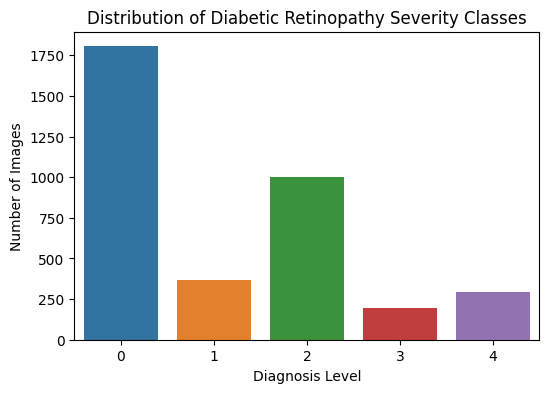

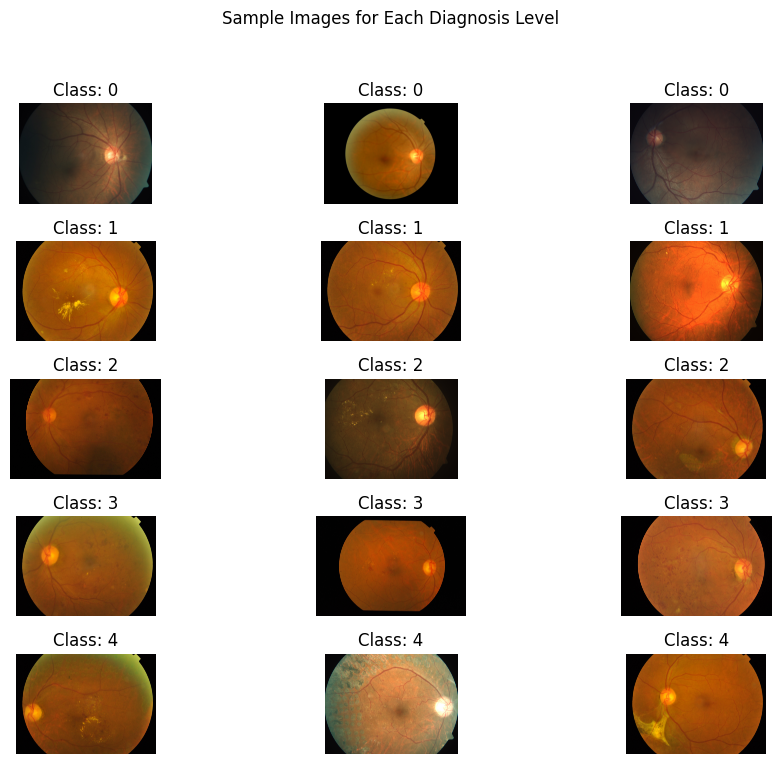

In [26]:
# Cell 2: Visualize Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diagnosis', data=train_df)
plt.title('Distribution of Diabetic Retinopathy Severity Classes')
plt.xlabel('Diagnosis Level')
plt.ylabel('Number of Images')
plt.show()

# --- Display Sample Images ---
def display_samples(df, num_samples_per_class=3):
    fig, axes = plt.subplots(5, num_samples_per_class, figsize=(15, 12))
    fig.suptitle('Sample Images for Each Diagnosis Level', fontsize=12)
    for i in range(5):
        sample_df = df[df['diagnosis'] == i].sample(num_samples_per_class)
        for j, (idx, row) in enumerate(sample_df.iterrows()):
            img_path = os.path.join(TRAIN_IMG_PATH, f"{row['id_code']}.png")
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'Class: {i}')
            axes[i, j].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

display_samples(train_df)

In [27]:
# Cell 3: Define Augmentations and Dataset Class
IMAGE_SIZE = 224

# Define transforms for training and validation
# Training transforms include augmentations to make the model more robust
train_transforms = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Validation/Test transforms only resize and normalize
val_test_transforms = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

class DRDataset(Dataset):
    def __init__(self, df, img_dir, transforms=None, is_test=False):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row.id_code}.png")
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']

        if self.is_test:
            return image
        else:
            return image, torch.tensor(row.diagnosis, dtype=torch.long)

# --- Split data and create DataLoaders ---
# Use stratified split to maintain class distribution in train/val sets
X_train, X_val = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['diagnosis']
)

train_dataset = DRDataset(X_train, TRAIN_IMG_PATH, transforms=train_transforms)
val_dataset = DRDataset(X_val, TRAIN_IMG_PATH, transforms=val_test_transforms)

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 2929, Validation samples: 733


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [28]:
# Cell 4: Model, Loss, Optimizer, and Training Loop

# --- Model Definition ---
# Using a pre-trained EfficientNet-B0 from timm
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=5)
model.to(DEVICE)

# --- Hyperparameters ---
LEARNING_RATE = 1e-4
EPOCHS = 5 # For a quick demonstration. Use more epochs (15-20) for better results.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# A learning rate scheduler can help improve training
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

# --- Training and Validation Loop ---
best_kappa = 0.0

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

    print(f"Epoch {epoch+1}/{EPOCHS} -> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Kappa: {kappa:.4f}")

    # Update learning rate scheduler
    scheduler.step(kappa)

    # Save the best model based on kappa score
    if kappa > best_kappa:
        print(f"Kappa score improved from {best_kappa:.4f} to {kappa:.4f}. Saving model...")
        best_kappa = kappa
        torch.save(model.state_dict(), 'best_model.pth')

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/5 [Validation]: 100%|██████████| 23/23 [00:59<00:00,  2.59s/it]


Epoch 1/5 -> Train Loss: 1.2822, Val Loss: 0.9302, Val Kappa: 0.7715
Kappa score improved from 0.0000 to 0.7715. Saving model...


Epoch 2/5 [Validation]: 100%|██████████| 23/23 [00:54<00:00,  2.38s/it]


Epoch 2/5 -> Train Loss: 0.6864, Val Loss: 0.8137, Val Kappa: 0.8257
Kappa score improved from 0.7715 to 0.8257. Saving model...


Epoch 3/5 [Validation]: 100%|██████████| 23/23 [00:56<00:00,  2.44s/it]


Epoch 3/5 -> Train Loss: 0.5194, Val Loss: 0.7354, Val Kappa: 0.8114


Epoch 4/5 [Validation]: 100%|██████████| 23/23 [00:54<00:00,  2.36s/it]


Epoch 4/5 -> Train Loss: 0.3976, Val Loss: 0.6956, Val Kappa: 0.8233


Epoch 5/5 [Validation]: 100%|██████████| 23/23 [00:58<00:00,  2.53s/it]

Epoch 5/5 -> Train Loss: 0.3602, Val Loss: 0.6873, Val Kappa: 0.8282
Kappa score improved from 0.8257 to 0.8282. Saving model...


In [29]:
# Cell 5: Inference on Test Set and Submission File Generation

# --- Load the best model weights ---
print(f"Loading best model with Kappa score: {best_kappa:.4f}")
model.load_state_dict(torch.load('best_model.pth'))
model.to(DEVICE)
model.eval()

# --- Create Test Dataset and DataLoader ---
test_dataset = DRDataset(test_df, TEST_IMG_PATH, transforms=val_test_transforms, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- Generate Predictions ---
test_preds = []
with torch.no_grad():
    for images in tqdm(test_loader, desc="Generating predictions"):
        images = images.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())

# --- Create Submission File ---
submission_df = pd.DataFrame({'id_code': test_df['id_code'], 'diagnosis': test_preds})
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file created successfully!")
print(submission_df.head())

Loading best model with Kappa score: 0.8282


Generating predictions: 100%|██████████| 61/61 [01:13<00:00,  1.21s/it]


Submission file created successfully!
        id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          2
2  006efc72b638          4
3  00836aaacf06          2
4  009245722fa4          2


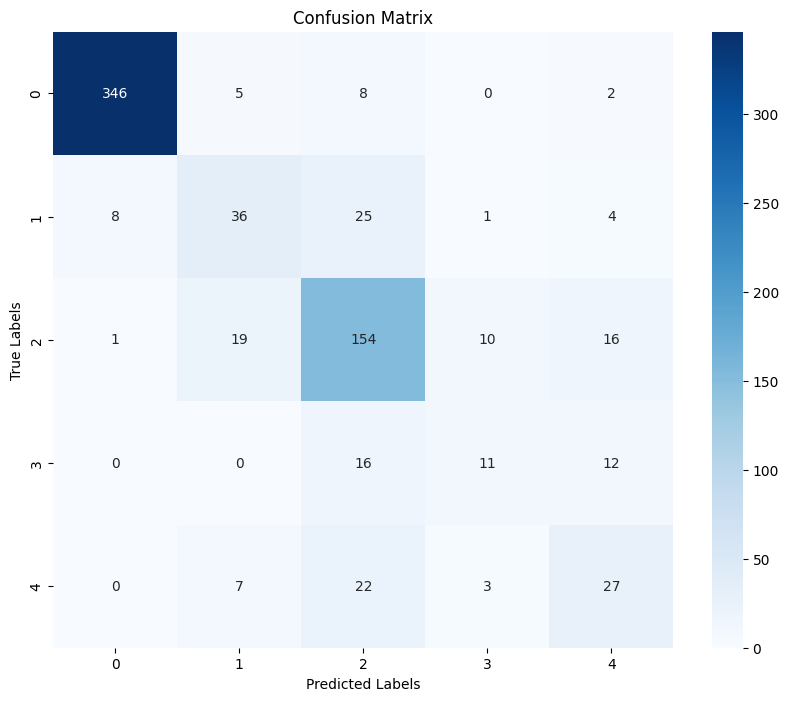

In [31]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot it as a heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
from sklearn.metrics import classification_report

# Print a detailed report
report = classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(5)])
print(report)

              precision    recall  f1-score   support

     Class 0       0.97      0.96      0.97       361
     Class 1       0.54      0.49      0.51        74
     Class 2       0.68      0.77      0.72       200
     Class 3       0.44      0.28      0.34        39
     Class 4       0.44      0.46      0.45        59

    accuracy                           0.78       733
   macro avg       0.62      0.59      0.60       733
weighted avg       0.78      0.78      0.78       733

